## Problem Statement

Credit Card Lead Prediction

Happy Customer Bank is a mid-sized private bank that deals in all kinds of banking products, like Savings accounts, Current accounts, investment products, credit products, among other offerings.


The bank also cross-sells products to its existing customers and to do so they use different kinds of communication like tele-calling, e-mails, recommendations on net banking, mobile banking, etc. 


In this case, the Happy Customer Bank wants to cross sell its credit cards to its existing customers. The bank has identified a set of customers that are eligible for taking these credit cards.


Now, the bank is looking for your help in identifying customers that could show higher intent towards a recommended credit card, given:

    Customer details (gender, age, region etc.)
    Details of his/her relationship with the bank (Channel_Code,Vintage, 'Avg_Asset_Value etc.)


## Deciding Models

In [1]:
# !pip install seaborn
# !pip install lightgbm
# !pip install optuna
# !pip install imblearn

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import seaborn as sns
sns.set()

from sklearn.linear_model import LinearRegression

In [5]:
# Load Train dataset
train_sdf = pd.read_csv('/usr/local/myapp/src/dataset/CreditCardTrain.csv')

## Dataset Overview

In [6]:
train_sdf.head(3)

ID  Gender  Age Region_Code     Occupation Channel_Code  Vintage  \
0  NNVBBKZB  Female   73       RG268          Other           X3       43   
1  IDD62UNG  Female   30       RG277       Salaried           X1       32   
2  HD3DSEMC  Female   56       RG268  Self_Employed           X3       26   

  Credit_Product  Avg_Account_Balance Is_Active  Is_Lead  
0             No              1045696        No        0  
1             No               581988        No        0  
2             No              1484315       Yes        0

In [7]:
print("***** Shape of dataset is (Rows, Columns) *****")
print()
train_sdf.shape   #shape of training data

***** Shape of dataset is (Rows, Columns) *****



(245725, 11)

In [8]:
print("***** List of Columnspresent in dataset *****")
print()
train_sdf.columns  #Column names

***** List of Columnspresent in dataset *****



Index(['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active',
       'Is_Lead'],
      dtype='object')

In [9]:
print("***** List of Columns present in dataset *****")
train_sdf.info()

***** List of Columns present in dataset *****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


In [10]:
print("**** This method gives us very nice descriptive statistics. We don't need this for now, but will later on! ****")
train_sdf.describe()

**** This method gives us very nice descriptive statistics. We don't need this for now, but will later on! ****


Age        Vintage  Avg_Account_Balance        Is_Lead
count  245725.000000  245725.000000         2.457250e+05  245725.000000
mean       43.856307      46.959141         1.128403e+06       0.237208
std        14.828672      32.353136         8.529364e+05       0.425372
min        23.000000       7.000000         2.079000e+04       0.000000
25%        30.000000      20.000000         6.043100e+05       0.000000
50%        43.000000      32.000000         8.946010e+05       0.000000
75%        54.000000      73.000000         1.366666e+06       0.000000
max        85.000000     135.000000         1.035201e+07       1.000000

## Cleaning Data Set

In [11]:
train_sdf.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

### Clean missing data - Impute missing data from frequently used values

In [12]:
# Iterate over each column of train_sdf
for col in train_sdf.columns:
    # Check if the column is of object type
    if train_sdf[col].dtypes == 'object':
        # Impute with the most frequent value
        train_sdf = train_sdf.fillna(train_sdf[col].value_counts().index[0])


In [13]:
train_sdf.isnull().sum()

ID                     0
Gender                 0
Age                    0
Region_Code            0
Occupation             0
Channel_Code           0
Vintage                0
Credit_Product         0
Avg_Account_Balance    0
Is_Active              0
Is_Lead                0
dtype: int64

In [14]:
# Count the number of NaNs in the dataset and print the counts to verify
train_sdf.isnull().values.sum()

0

In [15]:
train_sdf.head(3)

ID  Gender  Age Region_Code     Occupation Channel_Code  Vintage  \
0  NNVBBKZB  Female   73       RG268          Other           X3       43   
1  IDD62UNG  Female   30       RG277       Salaried           X1       32   
2  HD3DSEMC  Female   56       RG268  Self_Employed           X3       26   

  Credit_Product  Avg_Account_Balance Is_Active  Is_Lead  
0             No              1045696        No        0  
1             No               581988        No        0  
2             No              1484315       Yes        0

## Get Unique Value Count

In [16]:
columns=[ 'Gender', 'Region_Code', 'Occupation', 'Channel_Code',
        'Credit_Product', 'Is_Active','Is_Lead']

for i in columns:
    print("***************************************************")
    print(i)
    print("***************************************************")
    print("Value counts of",i,"is :")
    print(train_sdf[i].value_counts())
    print()
    print("Unique values of",i,"is :",train_sdf[i].unique()) 
    

***************************************************
Gender
***************************************************
Value counts of Gender is :
Male      134197
Female    111528
Name: Gender, dtype: int64

Unique values of Gender is : ['Female' 'Male']
***************************************************
Region_Code
***************************************************
Value counts of Region_Code is :
RG268    35934
RG283    29416
RG254    26840
RG284    19320
RG277    12826
RG280    12775
RG269     7863
RG270     7720
RG261     7633
RG257     6101
RG251     5950
RG282     5829
RG274     5286
RG272     5252
RG281     5093
RG273     4497
RG252     4286
RG279     3976
RG263     3687
RG275     3245
RG260     3110
RG256     2847
RG264     2793
RG276     2764
RG259     2586
RG250     2496
RG255     2018
RG258     1951
RG253     1858
RG278     1822
RG262     1788
RG266     1578
RG265     1546
RG271     1542
RG267     1497
Name: Region_Code, dtype: int64

Unique values of Region_Code is : ['RG268' 'R

### Exploratory Data Analysis

/usr/local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Credit_Product', ylabel='count'>

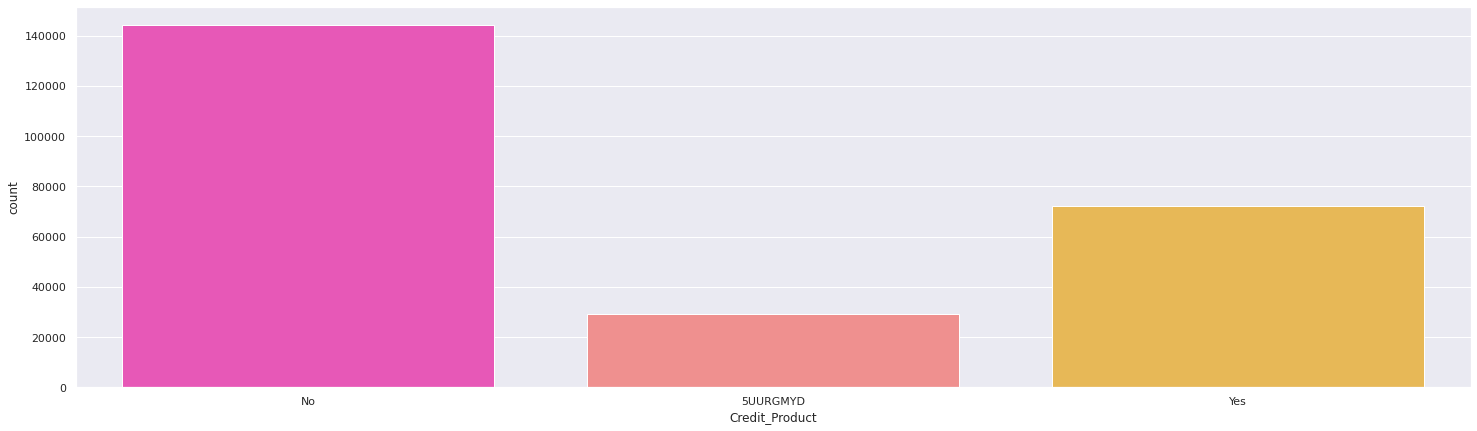

In [17]:
plt.figure(figsize=(25,7))
sns.countplot('Credit_Product',data=train_sdf,palette='spring')

/usr/local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Vintage', ylabel='count'>

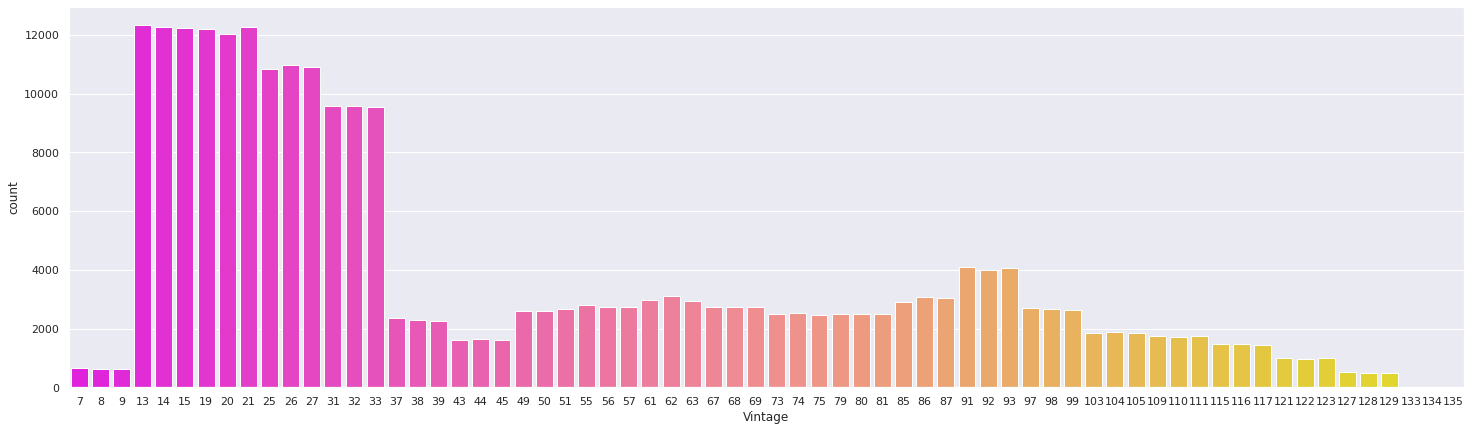

In [18]:
plt.figure(figsize=(25,7))
sns.countplot('Vintage',data=train_sdf,palette='spring')

/usr/local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Region_Code', ylabel='count'>

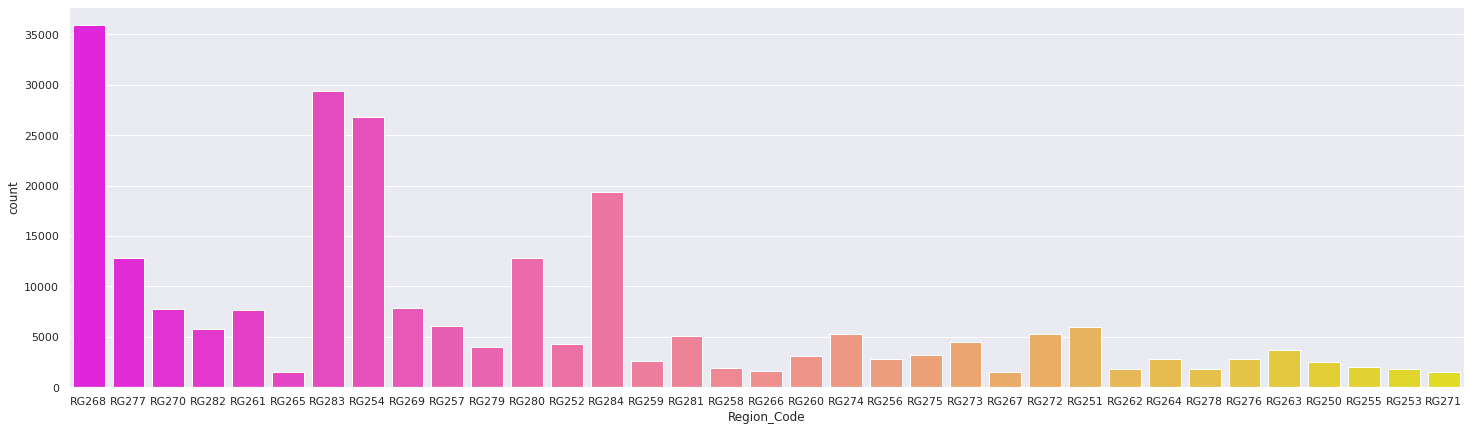

In [19]:
plt.figure(figsize=(25,7))
sns.countplot('Region_Code',data=train_sdf,palette='spring')

/usr/local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Channel_Code', ylabel='count'>

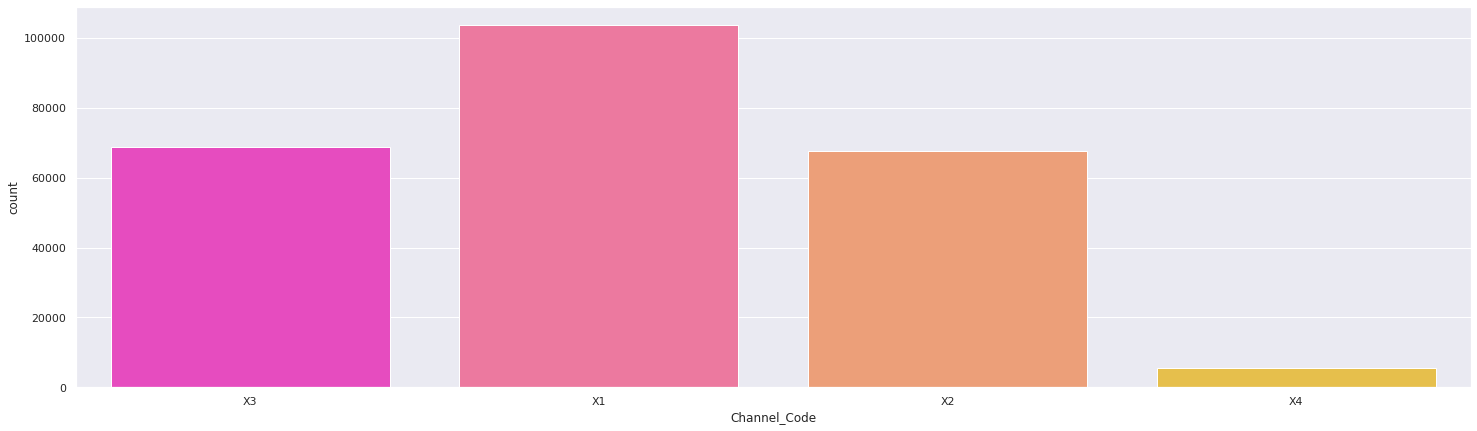

In [20]:
plt.figure(figsize=(25,7))
sns.countplot('Channel_Code',data=train_sdf,palette='spring')

/usr/local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Age', ylabel='count'>

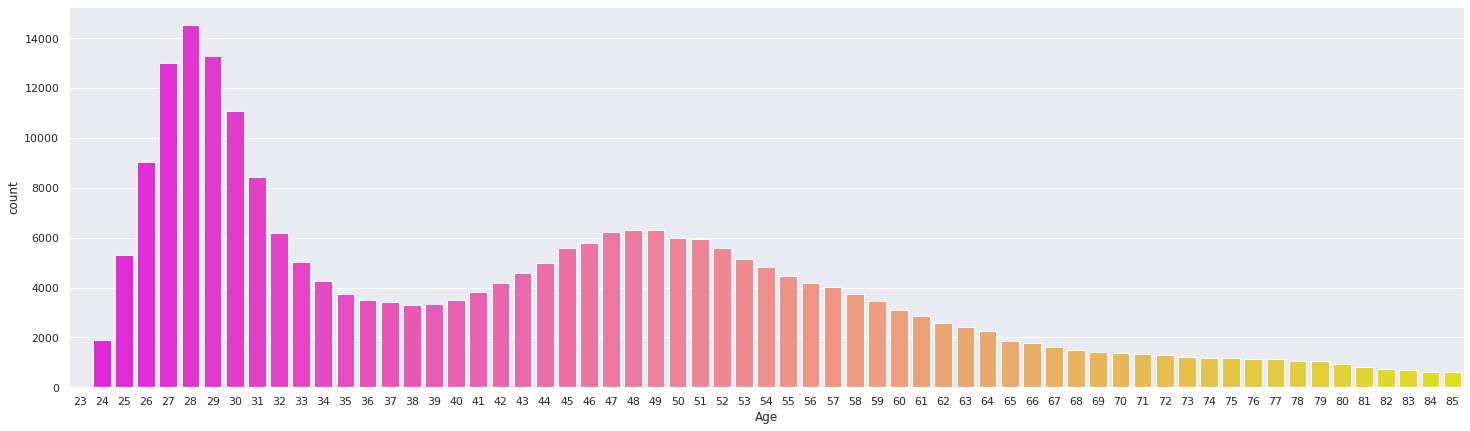

In [21]:
plt.figure(figsize=(25,7))
sns.countplot('Age',data=train_sdf,palette='spring')

## Quick Visualize

In [22]:
def with_hue(data,feature,ax):
    
    #Numnber of categories
    num_of_cat=len([x for x in data[feature].unique() if x==x])
    
    bars=ax.patches
    
    for ind in range(num_of_cat):
        ##     Get every hue bar
        ##     ex. 8 X categories, 4 hues =>
        ##    [0, 8, 16, 24] are hue bars for 1st X category
        hueBars=bars[ind:][::num_of_cat] 
        # Get the total height (for percentages)
        total=sum([x.get_height() for x in hueBars])
        #Printing percentages on bar
        for bar in hueBars:
            percentage='{:.1f}%'.format(100 * bar.get_height()/total)
            ax.text(bar.get_x()+bar.get_width()/2.0,
                   bar.get_height(),
                   percentage,
                    ha="center",va="bottom",fontweight='bold',fontsize=14)
    

    
def without_hue(data,feature,ax):
    
    total=float(len(data))
    bars_plot=ax.patches
    
    for bars in bars_plot:
        percentage = '{:.1f}%'.format(100 * bars.get_height()/total)
        x = bars.get_x() + bars.get_width()/2.0
        y = bars.get_height()
        ax.text(x, y,(percentage,bars.get_height()),ha='center',fontweight='bold',fontsize=14)

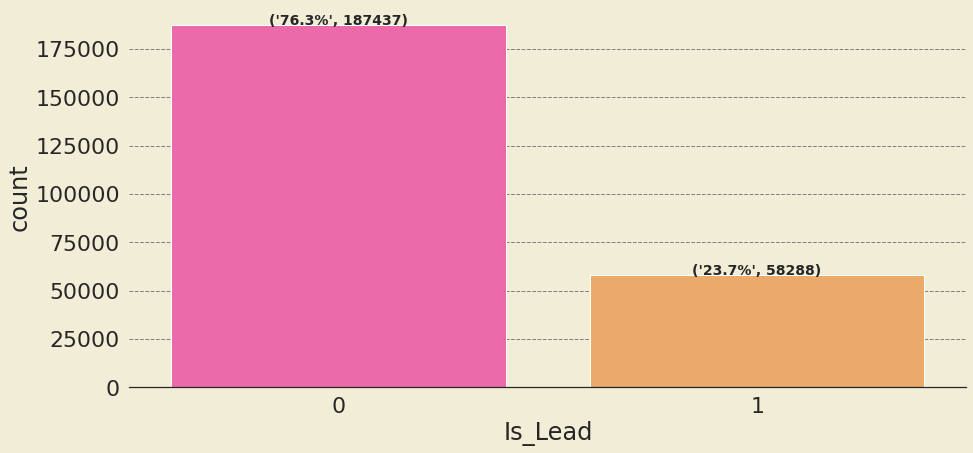

In [23]:
sns.set_theme(context="notebook",style="white",font_scale=2)
fig=plt.figure(figsize=(15,7))

#Setting plot and background color
ax = plt.axes() 
ax.set_facecolor("#F2EDD7FF") 
fig.patch.set_facecolor("#F2EDD7FF")

#Dealing with spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(linestyle="--",axis='y',color='gray')

a=sns.countplot(data=train_sdf,x='Is_Lead',palette='spring')
without_hue(train_sdf,'Is_Lead',a)

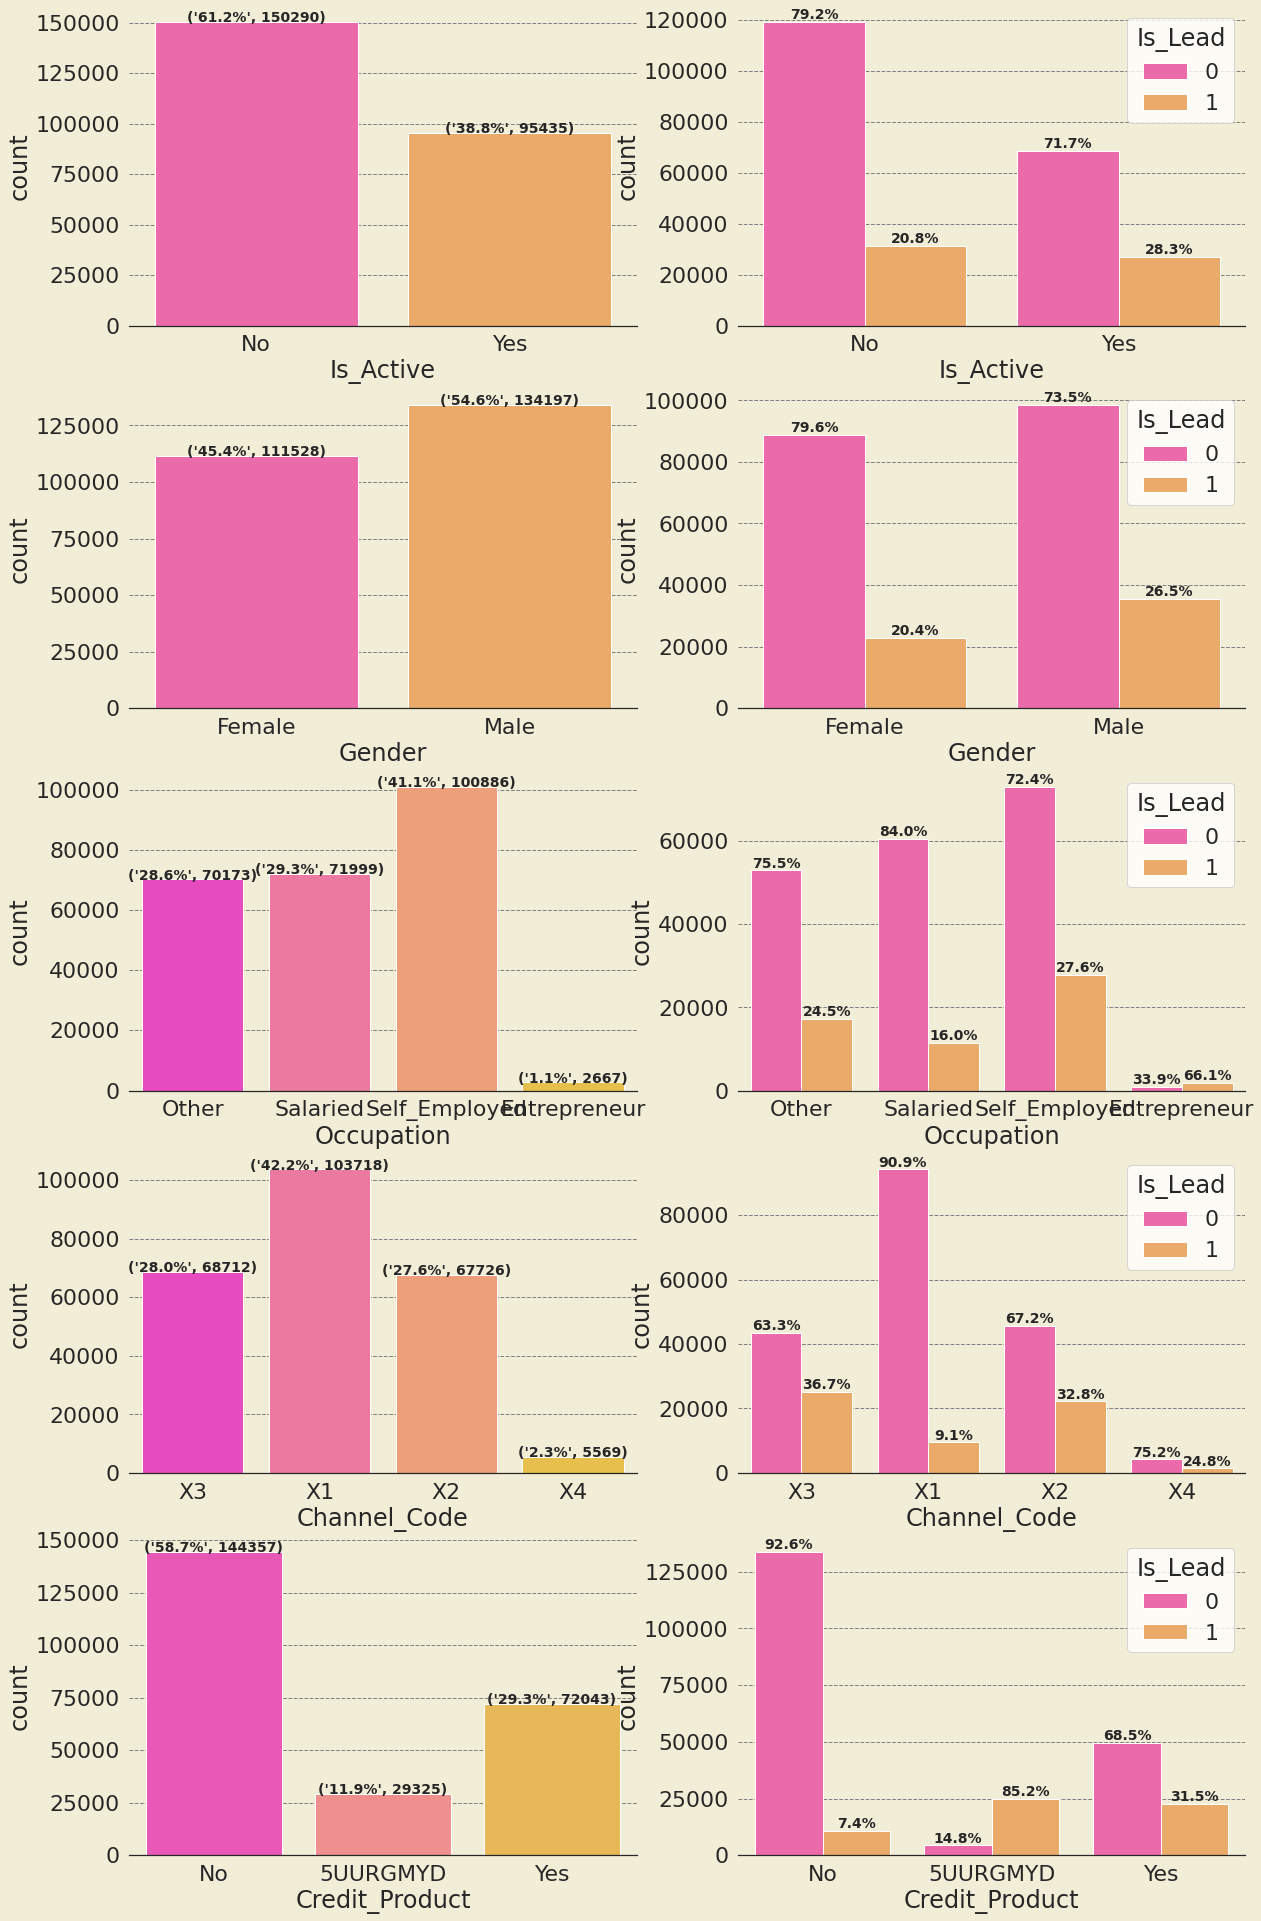

In [24]:
nrows=5
ncols=2
f,ax=plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,34))
columns=['Gender','Occupation', 'Channel_Code','Credit_Product', 'Is_Active']

f.patch.set_facecolor('#F2EDD7FF')

    #Setting background and foreground color
for i in range(0,nrows):
  for j in range(0,ncols):
    ax[i][j].set_facecolor('#F2EDD7FF')
    ax[i][j].spines['top'].set_visible(False)
    ax[i][j].spines['right'].set_visible(False)
    ax[i][j].spines['left'].set_visible(False)
    ax[i][j].grid(linestyle="--",axis='y',color='gray')


    if(j==0):
      a1=sns.countplot(data=train_sdf,x=columns[i-1],palette='spring',ax=ax[i][j])
      without_hue(train_sdf,columns[i-1],a1)
    elif(j==1):
      a2=sns.countplot(data=train_sdf,x=columns[i-1],palette='spring',ax=ax[i][j],hue="Is_Lead")
      with_hue(train_sdf,columns[i-1],a2)

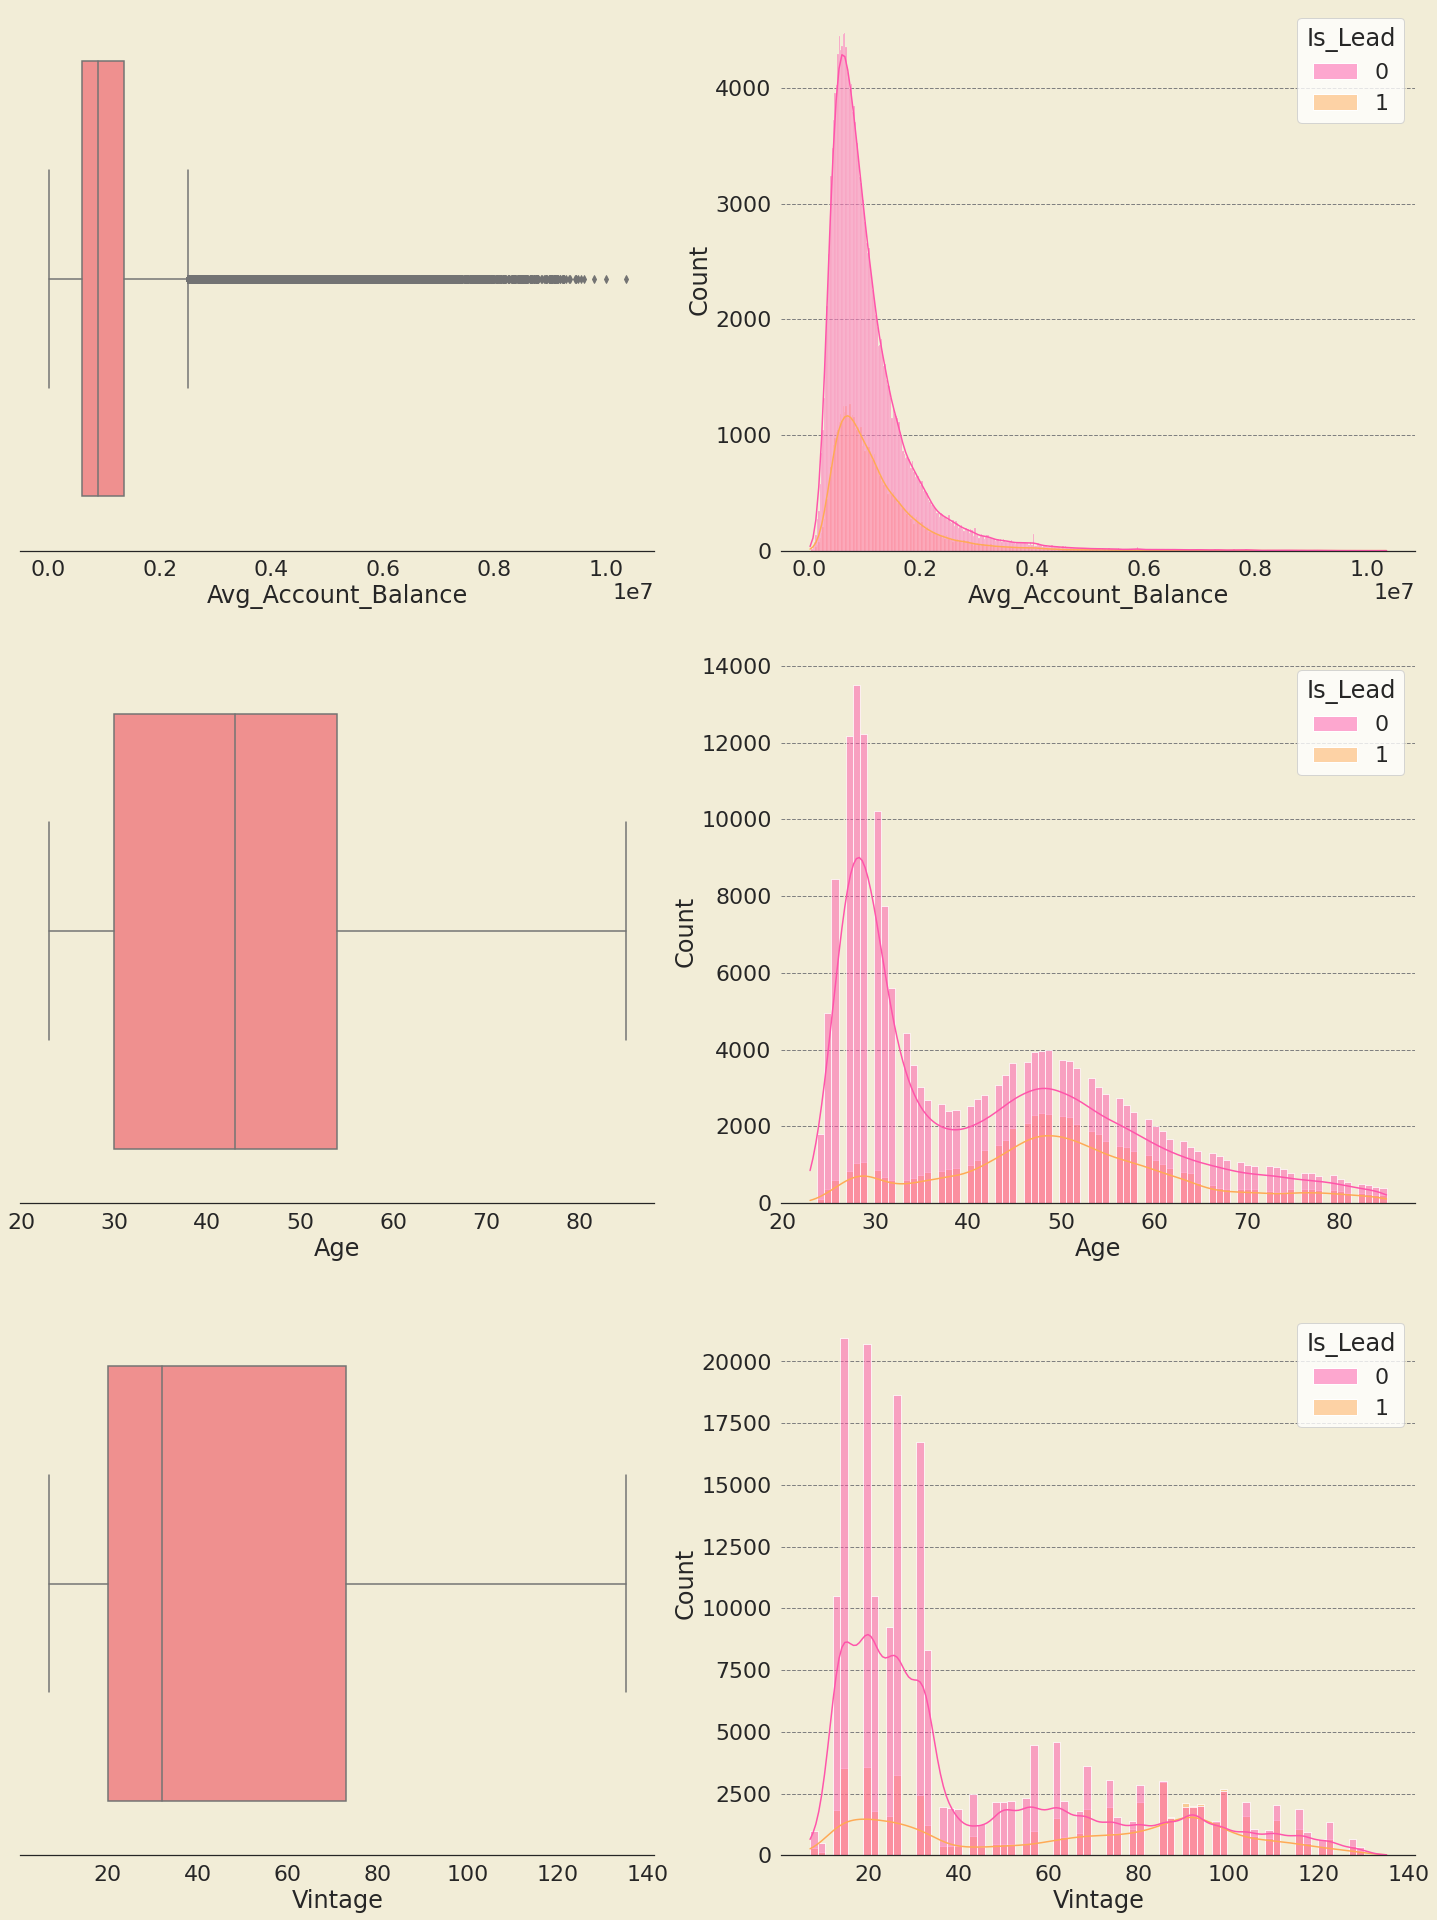

In [25]:
nrows=3
ncols=2
f,ax=plt.subplots(nrows=nrows,ncols=ncols,figsize=(25,34))
columns=["Age","Vintage","Avg_Account_Balance"]

f.patch.set_facecolor('#F2EDD7FF')

    #Setting background and foreground color
for i in range(0,nrows):
  for j in range(0,ncols):
    ax[i][j].set_facecolor('#F2EDD7FF')
    ax[i][j].spines['top'].set_visible(False)
    ax[i][j].spines['right'].set_visible(False)
    ax[i][j].spines['left'].set_visible(False)
    ax[i][j].grid(linestyle="--",axis='y',color='gray')


    if(j==0):
      a1=sns.boxplot(data=train_sdf,x=(train_sdf[columns[i-1]]),palette='spring',ax=ax[i][j])
    elif(j==1):
      a2=sns.histplot(data=train_sdf,x=(train_sdf[columns[i-1]]),palette='spring',ax=ax[i][j],hue="Is_Lead",kde=True)

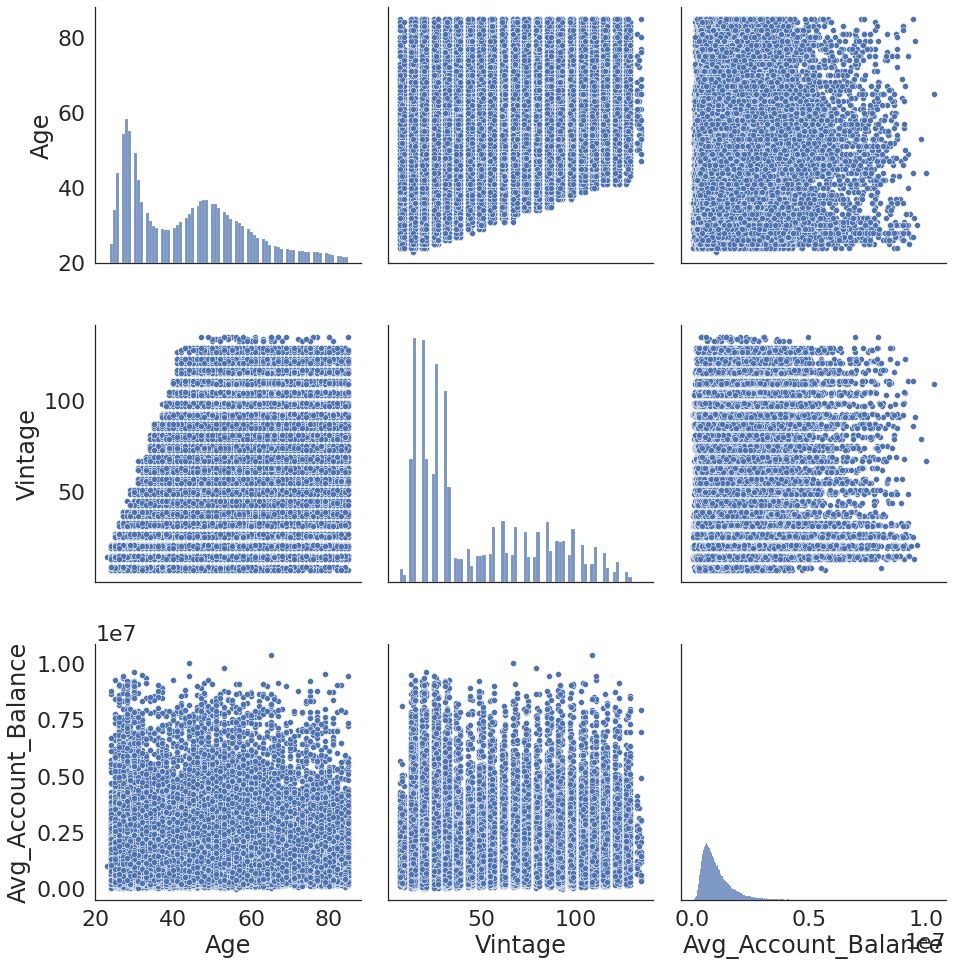

In [26]:

xvars=['Age',"Vintage",'Avg_Account_Balance']
yvars=['Age','Vintage',"Avg_Account_Balance"]
g=sns.pairplot(data=train_sdf,x_vars=xvars,y_vars=yvars,palette="spring")
g.fig.set_size_inches(15,15)

## Convert Categorial Value to Integer

In [27]:
# Import LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Instantiate LabelEncoder
le = LabelEncoder()

# Iterate over all the values of each column and extract their dtypes
for col in train_sdf.columns:
    # Compare if the dtype is object
    if train_sdf[col].dtype=='object':
    # Use LabelEncoder to do the numeric transformation
        train_sdf[col]=le.fit_transform(train_sdf[col])

In [28]:
train_sdf.head(3)

ID  Gender  Age  Region_Code  Occupation  Channel_Code  Vintage  \
0  179194       0   73           18           1             2       43   
1  131013       0   30           27           2             0       32   
2  121520       0   56           18           3             2       26   

   Credit_Product  Avg_Account_Balance  Is_Active  Is_Lead  
0               1              1045696          0        0  
1               1               581988          0        0  
2               1              1484315          1        0

<AxesSubplot:>

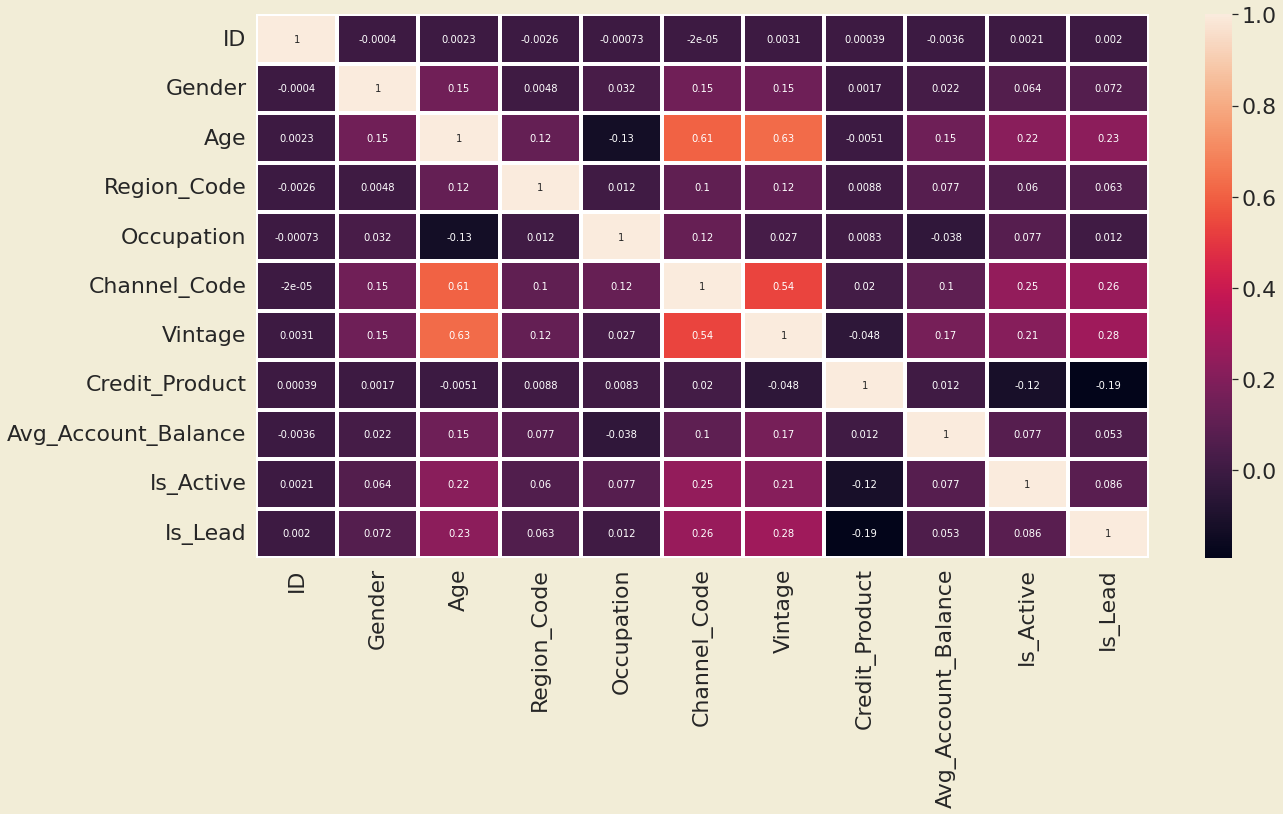

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
fig= plt.figure(figsize=(20,10))
ax = plt.axes() 
ax.set_facecolor("#F2EDD7FF") 
fig.patch.set_facecolor("#F2EDD7FF")

sns.heatmap(data=train_sdf.corr(),annot=True,linewidth=3)

## Select Features

In [30]:
Y=train_sdf['Is_Lead']
X=train_sdf.drop(["Is_Lead", "ID"],axis=1)

In [31]:
X.shape

(245725, 9)

## Split Tarin and Test Data

In [32]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=42)

In [33]:
Y.value_counts()

0    187437
1     58288
Name: Is_Lead, dtype: int64

In [34]:
y_train.value_counts()

0    131177
1     40830
Name: Is_Lead, dtype: int64

In [35]:
y_test.value_counts()

0    56260
1    17458
Name: Is_Lead, dtype: int64

## Import required libraries

In [36]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
import optuna
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score,train_test_split , StratifiedKFold
from sklearn.metrics import roc_auc_score , f1_score , confusion_matrix , classification_report
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
import matplotlib.pyplot as pyplot

In [37]:
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(x_train, y_train)
x_train_fs = fs.transform(x_train)
x_test_fs = fs.transform(x_test)

Feature 0: 438.797098
Feature 1: 46351.855623
Feature 2: 3793.022307
Feature 3: 8.613203
Feature 4: 10267.680442
Feature 5: 303132.211046
Feature 6: 2051.692543
Feature 7: 287325614.020401
Feature 8: 786.047614


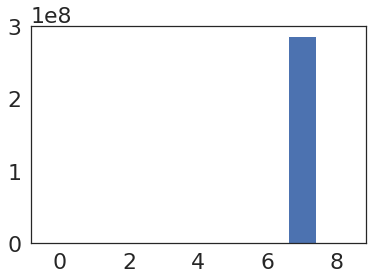

In [38]:
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

## TRAIN AND TEST

### Decision Tree Classifier

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 

 
clf_tree_gini = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=100)
clf_tree_gini.fit(x_train, y_train)



DecisionTreeClassifier(max_depth=4, random_state=100)

In [40]:
y_pred=clf_tree_gini.predict(x_test)
print ("Accuracy : ", 
accuracy_score(y_test,y_pred)*100) 

Accuracy :  84.84223663148755


In [41]:
pickling_on = open("decisiontree_model_gini.pickle","wb")
pickle.dump(clf_tree_gini, pickling_on)
pickling_on.close()

In [42]:
# pickle_off = open("decisiontree_model_gini.pickle", 'rb')
# load_model = pickle.load(pickle_off)
# load_model.predict(x_test)

## Logistic Regression

In [43]:
from sklearn.linear_model import LogisticRegression
clf_LogisticRegression = LogisticRegression()

clf_LogisticRegression.fit(x_train,y_train)

pred_train = clf_LogisticRegression.predict(x_train)
pred_test = clf_LogisticRegression.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,y_train)
accuracy_test = accuracy_score(pred_test,y_test)

print(accuracy_train, accuracy_test)

0.7626259396419913 0.7631785995279308


In [44]:
pickling_on = open("logistic_regression.pickle","wb")
pickle.dump(clf_LogisticRegression, pickling_on)
pickling_on.close()

In [45]:
# pickle_off = open("logistic_regression.pickle", 'rb')
# load_model = pickle.load(pickle_off)
# load_model.predict(X_test)

## Random Forest

In [46]:
from sklearn.ensemble import RandomForestClassifier
clf_random_forest = RandomForestClassifier()

clf_random_forest.fit(x_train,y_train)

pred_train = clf_random_forest.predict(x_train)
pred_test = clf_random_forest.predict(x_test)

accuracy_train = accuracy_score(pred_train,y_train)
accuracy_test = accuracy_score(pred_test,y_test)

from sklearn import metrics


print(accuracy_train,accuracy_test)

0.999924421680513 0.852980276187634


In [47]:
pickling_on = open("random_forest.pickle","wb")
pickle.dump(clf_random_forest, pickling_on)
pickling_on.close()

In [48]:
# pickle_off = open("random_forest.pickle", 'rb')
# load_model = pickle.load(pickle_off)
# final_predictions = load_model.predict(prediction_test_ds)

##### Features and Labels

In [49]:
features_train = x_train
label_train = y_train
features_test =x_test
label_test = y_test

## Gaussian Model

In [50]:
from sklearn.naive_bayes import GaussianNB 
from sklearn.metrics import accuracy_score
clf_gauss = GaussianNB()

clf_gauss.fit(features_train,label_train)

pred_train = clf_gauss.predict(features_train)
pred_test = clf_gauss.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

print(accuracy_train,accuracy_test)

0.7563994488596394 0.7578339075938034


In [51]:
pickling_on = open("gaussian.pickle","wb")
pickle.dump(clf_gauss, pickling_on)
pickling_on.close()

In [52]:
# pickle_off = open("random_forest.pickle", 'rb')
# load_model = pickle.load(pickle_off)
# load_model.predict(x_test)

In [53]:
x_test

Gender  Age  Region_Code  Occupation  Channel_Code  Vintage  \
241356       0   82            1           1             1       51   
150884       1   52           30           3             2       62   
43550        1   31           34           2             0       25   
62555        0   33           18           3             0       27   
147096       1   30            1           2             0       19   
...        ...  ...          ...         ...           ...      ...   
109172       0   30            9           2             0       39   
66179        0   31           10           2             0       33   
198583       1   34           22           2             0       21   
122392       1   75           32           1             2      105   
190996       0   32           33           2             0       31   

        Credit_Product  Avg_Account_Balance  Is_Active  
241356               2               441769          0  
150884               1               661554          0  
43550                2              2151922          0  
62555                1              2525072          0  
147096               1              2156763          0  
...                ...                  ...        ...  
109172               1               436367          0  
66179                1               542303          0  
198583               1               481819          0  
122392               2              1015641          0  
190996               1               394448          0  

[73718 rows x 9 columns]

## Gradient Boosting Classifier

In [54]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

clf_gradient = GradientBoostingClassifier()

clf_gradient.fit(features_train,label_train)

pred_train = clf_gradient.predict(features_train)
pred_test = clf_gradient.predict(features_test)


accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

print(accuracy_train,accuracy_test)
print(pred_test)

0.8607149709023469 0.8596407932933612
[0 0 0 ... 0 0 0]


In [55]:
pickling_on = open("GBClassifier.pickle","wb")
pickle.dump(clf_gradient, pickling_on)
pickling_on.close()

In [56]:
# pickle_off = open("GBClassifier.pickle", 'rb')
# load_model = pickle.load(pickle_off)
# final_predictions = load_model.predict(x_test)

## LGBM

In [57]:
import lightgbm as lgb

In [58]:
def objective_lgbm(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 2, 500)
    max_depth = int(trial.suggest_int('max_depth', 2, 50))
    learning_rate=trial.suggest_loguniform('learning_rate',0.001,1)
    colsample_bytree=trial.suggest_loguniform("colsample_bytree",0.1, 1)
    num_leaves=trial.suggest_int('num_leaves',10,300)
    reg_alpha= trial.suggest_loguniform('reg_alpha',0.1,10)
    reg_lambda= trial.suggest_loguniform('reg_lambda',0.1,10)
    min_split_gain=trial.suggest_loguniform('min_split_gain',0.1,1)
    subsample=trial.suggest_loguniform('subsample',0.1,1)    
    clf = lgb.LGBMClassifier(n_estimators=n_estimators, max_depth=max_depth,
                            learning_rate=learning_rate,colsample_bytree=colsample_bytree,
                            num_leaves=num_leaves,reg_alpha=reg_alpha,reg_lambda=reg_lambda,
                            min_split_gain=min_split_gain,subsample=subsample)
    cv=StratifiedKFold(n_splits=5,random_state=42,shuffle=True)
    return cross_val_score(clf, x_train, y_train, 
           n_jobs=2, cv=5,scoring='roc_auc').mean()

In [59]:
study_lgbm= optuna.create_study(direction='maximize',study_name="LGBM")
study_lgbm.optimize(objective_lgbm, n_trials=15)

[I 2022-03-07 10:30:41,549] A new study created in memory with name: LGBM
[I 2022-03-07 10:30:47,177] Trial 0 finished with value: 0.8020230413353527 and parameters: {'n_estimators': 267, 'max_depth': 49, 'learning_rate': 0.0015966747016821264, 'colsample_bytree': 0.2552313362036598, 'num_leaves': 235, 'reg_alpha': 1.6328368489997354, 'reg_lambda': 2.502017730894501, 'min_split_gain': 0.11625204504809603, 'subsample': 0.29636471689179156}. Best is trial 0 with value: 0.8020230413353527.
[I 2022-03-07 10:30:49,784] Trial 1 finished with value: 0.870135980610933 and parameters: {'n_estimators': 499, 'max_depth': 28, 'learning_rate': 0.7473433645290627, 'colsample_bytree': 0.35563564723127783, 'num_leaves': 146, 'reg_alpha': 0.9050714607306918, 'reg_lambda': 0.5904007051405886, 'min_split_gain': 0.8838676598610266, 'subsample': 0.6796347078010188}. Best is trial 1 with value: 0.870135980610933.
[I 2022-03-07 10:30:55,434] Trial 2 finished with value: 0.8731414245746121 and parameters: {'n

In [60]:
trial_lgbm= study_lgbm.best_trial
print("## Accuracy --> ",trial_lgbm.value)
print("## Best parameters --> ",trial_lgbm.params)

## Accuracy -->  0.8738751038994076
## Best parameters -->  {'n_estimators': 482, 'max_depth': 36, 'learning_rate': 0.30844849517052525, 'colsample_bytree': 0.39176123183621486, 'num_leaves': 24, 'reg_alpha': 0.10219228544625356, 'reg_lambda': 1.72778544917509, 'min_split_gain': 0.3709812554771009, 'subsample': 0.10788497700074184}


In [61]:
#MODEL
model_lgbm=lgb.LGBMClassifier(**trial_lgbm.params)
model_lgbm.fit(x_train,y_train,eval_metric="auc",eval_set=[(x_test,y_test)],early_stopping_rounds=100,verbose=400)

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMClassifier(colsample_bytree=0.39176123183621486,
               learning_rate=0.30844849517052525, max_depth=36,
               min_split_gain=0.3709812554771009, n_estimators=482,
               num_leaves=24, reg_alpha=0.10219228544625356,
               reg_lambda=1.72778544917509, subsample=0.10788497700074184)

In [62]:
pred_lgbm=model_lgbm.predict_proba(x_test)[:,1]

In [63]:
print("***** roc_auc_score of LGBM *****")
print()
print(roc_auc_score(y_test,pred_lgbm))

***** roc_auc_score of LGBM *****

0.8714322341727403


In [65]:
pickling_on = open("LGBM.pickle","wb")
pickle.dump(model_lgbm, pickling_on)
pickling_on.close()

## For this data set, let's go with LGBM applied to get final submission

